# SDOF + TMD

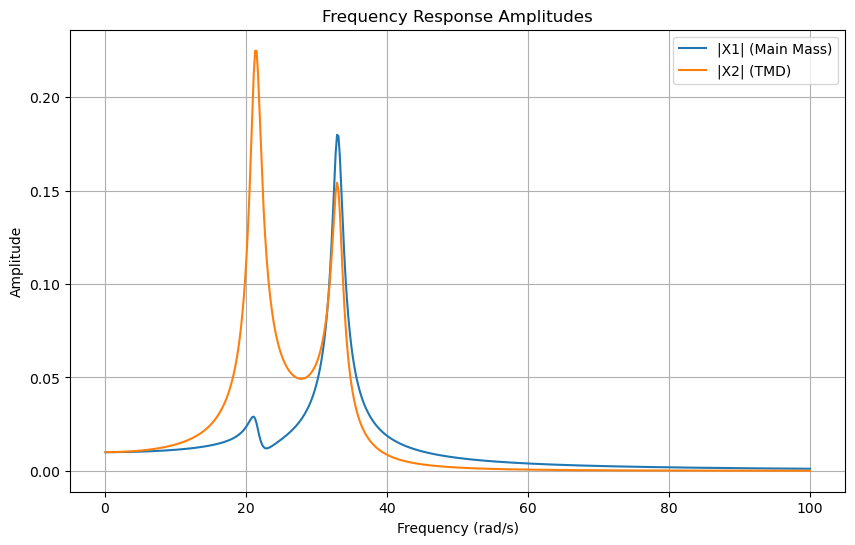

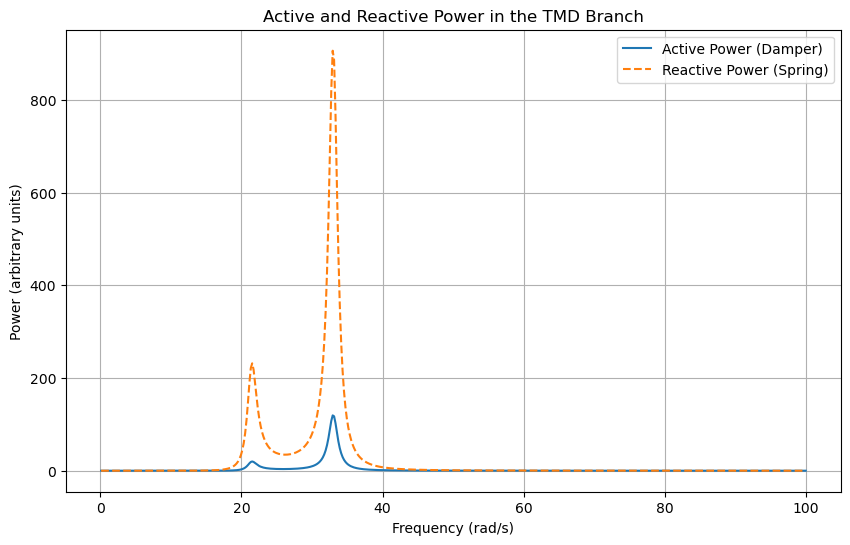

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
m1 = 10.0      # main mass
m2 = 1.0       # TMD mass
k1 = 1e4       # stiffness between main mass and ground
c1 = 10.0      # damping between main mass and ground
k2 = 500.0     # stiffness of TMD connection
c2 = 2.0       # damping of TMD connection
Y0 = 0.01      # base excitation amplitude

# Frequency range (avoid omega=0 to prevent singularities)
omega_vals = np.linspace(0.1, 100, 500)

# Arrays to store responses and power quantities
X1_vals = np.zeros(omega_vals.shape, dtype=complex)
X2_vals = np.zeros(omega_vals.shape, dtype=complex)
P_active = np.zeros(omega_vals.shape)   # Active (dissipated) power in TMD damper
Q_reactive = np.zeros(omega_vals.shape)   # Reactive power in TMD spring

for i, omega in enumerate(omega_vals):
    # Assemble matrix A(omega)
    A11 = -omega**2 * m1 + 1j*omega*(c1+c2) + (k1+k2)
    A12 = -(1j*omega*c2 + k2)
    A21 = -(1j*omega*c2 + k2)
    A22 = -omega**2 * m2 + 1j*omega*c2 + k2
    A = np.array([[A11, A12],
                  [A21, A22]], dtype=complex)
    
    # Forcing vector due to base excitation on m1 only.
    # Note: The forcing enters as (j*omega*c1+k1)*Y0.
    F = np.array([(1j*omega*c1 + k1)*Y0, 0], dtype=complex)
    
    # Solve for the complex displacements X1 and X2
    X = np.linalg.solve(A, F)
    X1, X2 = X[0], X[1]
    X1_vals[i] = X1
    X2_vals[i] = X2

    # Relative displacement across the TMD branch
    dX = X1 - X2
    # Compute power in the TMD branch
    # Damper (active) power: 0.5 * omega^2 * c2 * |dX|^2
    P_active[i] = 0.5 * omega**2 * c2 * np.abs(dX)**2
    # Spring (reactive) power: -0.5 * omega * k2 * |dX|^2
    Q_reactive[i] = -0.5 * omega * k2 * np.abs(dX)**2

# Plotting the amplitude responses
plt.figure(figsize=(10, 6))
plt.plot(omega_vals, np.abs(X1_vals), label="|X1| (Main Mass)")
plt.plot(omega_vals, np.abs(X2_vals), label="|X2| (TMD)")
plt.xlabel("Frequency (rad/s)")
plt.ylabel("Amplitude")
plt.title("Frequency Response Amplitudes")
plt.legend()
plt.grid(True)
plt.show()

# Plotting the power flows in the TMD branch
plt.figure(figsize=(10, 6))
plt.plot(omega_vals, P_active, label="Active Power (Damper)")
plt.plot(omega_vals, np.abs(Q_reactive), label="Reactive Power (Spring)", linestyle='--')
plt.xlabel("Frequency (rad/s)")
plt.ylabel("Power (arbitrary units)")
plt.title("Active and Reactive Power in the TMD Branch")
plt.legend()
plt.grid(True)
plt.show()


# 2 masses + TMD

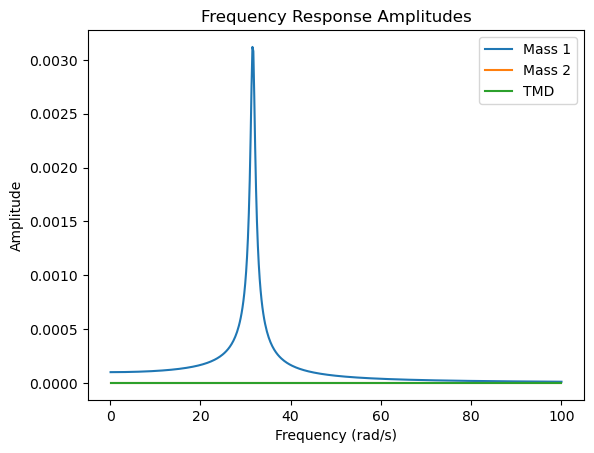

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define system parameters
m1, m2, m3 = 10.0, 8.0, 1.0     # masses
k1, k2, k3 = 1e4, 1.2e4, 0.0     # stiffnesses (example values; tune k3 later)
c1, c2, c3 = 10.0, 15.0, 0.0     # damping coefficients (example values; tune c3 later)

# Mass matrix
M = np.diag([m1, m2, m3])

# Stiffness and damping matrices (example connectivity)
K = np.array([
    [ k1,    0,    0 ],
    [  0,   k2,   -k2], 
    [  0,   -k2,  k2 + k3 ]
])
C = np.array([
    [ c1,    0,    0 ],
    [  0,   c2,   -c2],
    [  0,  -c2,   c2 + c3 ]
])

# Define frequency range (avoiding omega=0 can help)
omega_values = np.linspace(0.1, 100, 500)  # start from 0.1 rad/s

F_responses = []
for omega in omega_values:
    # For demonstration, excite the first degree-of-freedom with a unit amplitude forcing.
    F = np.array([1, 0, 0], dtype=complex)
    A = -omega**2 * M + 1j*omega*C + K
    try:
        X = np.linalg.solve(A, F)
    except np.linalg.LinAlgError:
        # In case A is singular for this omega, use np.linalg.lstsq or skip this omega.
        X, residuals, rank, s = np.linalg.lstsq(A, F, rcond=None)
    F_responses.append(X)

F_responses = np.array(F_responses)  # shape: (len(omega_values), 3)

# Compute amplitudes
A1 = np.abs(F_responses[:, 0])
A2 = np.abs(F_responses[:, 1])
A3 = np.abs(F_responses[:, 2])

# Plot frequency response
plt.figure()
plt.plot(omega_values, A1, label="Mass 1")
plt.plot(omega_values, A2, label="Mass 2")
plt.plot(omega_values, A3, label="TMD")
plt.xlabel("Frequency (rad/s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Frequency Response Amplitudes")
plt.show()


# Self Excitation    

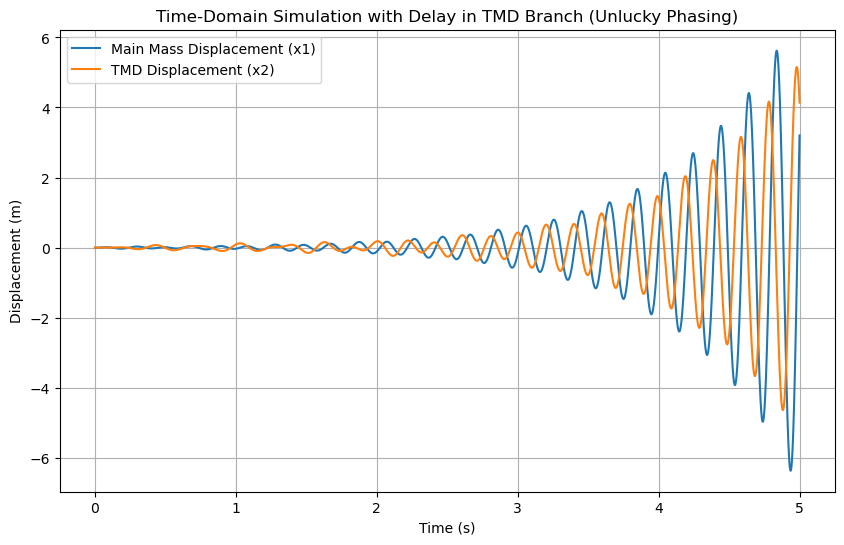

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# System Parameters
m1 = 10.0       # Main mass (kg)
m2 = 1.0        # TMD mass (kg)
k1 = 1e4        # Stiffness between main mass and ground (N/m)
c1 = 10.0       # Damping between main mass and ground (N·s/m)
k2 = 500.0      # Stiffness of TMD connection (N/m)
c2 = 2.0        # Damping of TMD connection (N·s/m)
Y0 = 0.01       # Base excitation amplitude (m)
omega_ex = 20.0 # Base excitation frequency (rad/s)

# Delay in the TMD branch (introduces additional phase lag)
tau = 0.05  # Delay in seconds

# Time Integration Parameters
T_end = 5.0     # Total simulation time in seconds
dt = 0.001      # Time step (s)
t_vals = np.arange(0, T_end + dt, dt)
N = len(t_vals)

# State vector: [x1, v1, x2, v2]
# x1: main mass displacement, v1: main mass velocity,
# x2: TMD displacement, v2: TMD velocity.
state = np.zeros((N, 4))
# Initial conditions (all at rest)
state[0, :] = [0.0, 0.0, 0.0, 0.0]

# Time-domain integration (Euler method)
for i in range(N - 1):
    t = t_vals[i]
    
    # Retrieve delayed x1 value: for times < tau, assume history is zero.
    if t - tau < 0:
        x1_delayed = 0.0
    else:
        # Interpolate to approximate x1 at time (t - tau)
        x1_delayed = np.interp(t - tau, t_vals[:i+1], state[:i+1, 0])
    
    # Unpack current state
    x1, v1, x2, v2 = state[i, :]
    
    # Base excitation: displacement and velocity of the ground
    y = Y0 * np.cos(omega_ex * t)
    ydot = -Y0 * omega_ex * np.sin(omega_ex * t)
    
    # Equations of motion:
    # Main mass equation (including base excitation)
    dx1dt = v1
    dv1dt = (- c1 * (v1 - ydot)
             - k1 * (x1 - y)
             - c2 * (v1 - v2)
             - k2 * (x1_delayed - x2)) / m1
    
    # TMD mass equation, note the delayed coupling from x1
    dx2dt = v2
    dv2dt = (- c2 * (v2 - v1)
             - k2 * (x2 - x1_delayed)) / m2
    
    # Euler integration step
    state[i + 1, 0] = x1 + dt * dx1dt
    state[i + 1, 1] = v1 + dt * dv1dt
    state[i + 1, 2] = x2 + dt * dx2dt
    state[i + 1, 3] = v2 + dt * dv2dt

# Plot the displacements of the main mass and the TMD over time
plt.figure(figsize=(10, 6))
plt.plot(t_vals, state[:, 0], label='Main Mass Displacement (x1)')
plt.plot(t_vals, state[:, 2], label='TMD Displacement (x2)')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Time-Domain Simulation with Delay in TMD Branch (Unlucky Phasing)')
plt.legend()
plt.grid(True)
plt.show()


# TD + FD for instable system

Frequency Domain Solution at ω = 20.00 rad/s
Main Mass (X1): Amplitude = 2.3330e-02 m, Phase = -0.156 rad
TMD      (X2): Amplitude = 1.0865e-01 m, Phase = -0.457 rad


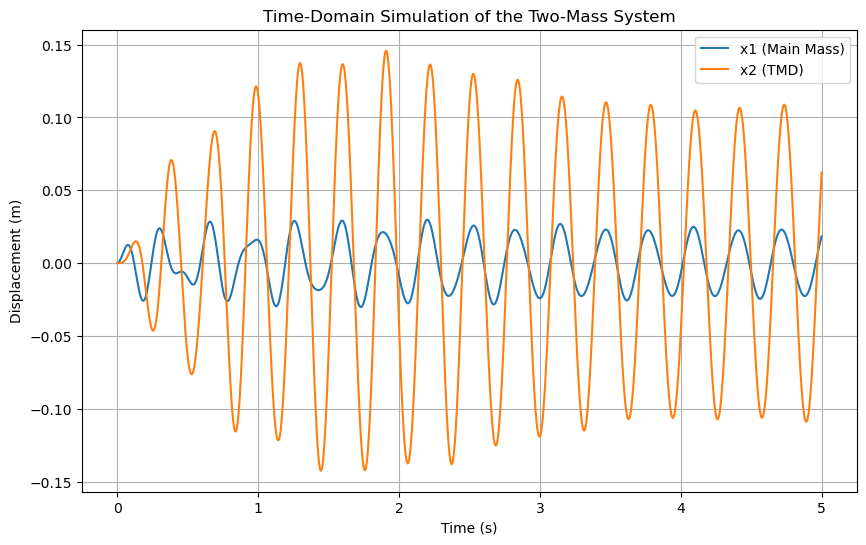


Time Domain (Steady-State) Estimates:
Main Mass (x1): Amplitude = 2.3843e-02 m, Phase = -0.117 rad
TMD      (x2): Amplitude = 1.1237e-01 m, Phase = -0.349 rad

Comparison (Time Domain vs. Frequency Domain):
Main Mass Amplitude: TD = 2.3843e-02 m, FD = 2.3330e-02 m
Main Mass Phase:     TD = -0.117 rad, FD = -0.156 rad
TMD Amplitude:       TD = 1.1237e-01 m, FD = 1.0865e-01 m
TMD Phase:           TD = -0.349 rad, FD = -0.457 rad


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# For phase extraction, we will average over a steady-state window
def extract_amplitude_phase(t, x, omega):
    """
    Given a time series t, signal x, and excitation frequency omega,
    estimate the amplitude and phase of the steady-state response assuming
    a model: x(t) = A*cos(omega*t + phi).
    """
    # Use only the steady-state portion (e.g., the second half of the data)
    N = len(t)
    steady_start = N // 2
    t_steady = t[steady_start:]
    x_steady = x[steady_start:]
    
    # Compute in-phase and quadrature components using correlation
    # The integrals are approximated by sums (assuming uniform dt)
    dt = t[1] - t[0]
    a = (2 / (t_steady[-1] - t_steady[0])) * np.trapz(x_steady * np.cos(omega * t_steady), t_steady)
    b = (2 / (t_steady[-1] - t_steady[0])) * np.trapz(x_steady * np.sin(omega * t_steady), t_steady)
    # For x(t) = A*cos(omega*t+phi), one obtains:
    #   a = A*cos(phi)  and b = -A*sin(phi)
    A_est = np.sqrt(a**2 + b**2)
    phi_est = np.arctan2(-b, a)  # negative b because of the cosine representation
    return A_est, phi_est

# --------------------------
# Define system parameters
# --------------------------
m1 = 10.0      # main mass (kg)
m2 = 1.0       # TMD mass (kg)

k1 = 1e4       # stiffness between main mass and ground (N/m)
c1 = 10.0      # damping between main mass and ground (N·s/m)

k2 = 500.0     # stiffness in TMD branch (N/m)
c2 = 2.0       # damping in TMD branch (N·s/m)

Y0 = 0.01      # Base excitation amplitude (m)
omega_ex = 20.0  # Excitation frequency (rad/s)

# ------------------------------------------
# Frequency-domain solution at omega_ex
# ------------------------------------------
# The equations (using absolute displacements) are:
#   [ -omega^2*m1 + j*omega*(c1+c2) + (k1+k2)     -(j*omega*c2 + k2)        ] [X1] =
#   [ (j*omega*c1 + k1)*Y0                                              0           ] [X2]
#
#   [ -(j*omega*c2 + k2)         -omega^2*m2 + j*omega*c2 + k2 ] [X2] = [   0  ]
A11 = -omega_ex**2 * m1 + 1j * omega_ex * (c1 + c2) + (k1 + k2)
A12 = -(1j * omega_ex * c2 + k2)
A21 = A12
A22 = -omega_ex**2 * m2 + 1j * omega_ex * c2 + k2

A_mat = np.array([[A11, A12],
                  [A21, A22]], dtype=complex)

F_vec = np.array([(1j * omega_ex * c1 + k1) * Y0, 0], dtype=complex)

X = np.linalg.solve(A_mat, F_vec)
X1_fd, X2_fd = X[0], X[1]

print("Frequency Domain Solution at ω = {:.2f} rad/s".format(omega_ex))
print("Main Mass (X1): Amplitude = {:.4e} m, Phase = {:.3f} rad".format(np.abs(X1_fd), np.angle(X1_fd)))
print("TMD      (X2): Amplitude = {:.4e} m, Phase = {:.3f} rad".format(np.abs(X2_fd), np.angle(X2_fd)))

# ---------------------------------------------------
# Time-domain simulation of the same two-mass system
# ---------------------------------------------------
# Equations of motion:
#   m1*x1'' = - c1*(x1' - y') - k1*(x1 - y) - c2*(x1' - x2') - k2*(x1 - x2)
#   m2*x2'' = - c2*(x2' - x1') - k2*(x2 - x1)
# with base displacement: y(t) = Y0*cos(omega_ex*t)
# (No delay is used so that the system exactly corresponds to the frequency-domain model.)

T_end = 5.0       # Total simulation time (s)
dt = 0.0005       # Time step (s)
t_vals = np.arange(0, T_end, dt)
N = len(t_vals)

# Initialize state: [x1, v1, x2, v2]
state = np.zeros((N, 4))
# Initial conditions: start at rest
state[0, :] = [0.0, 0.0, 0.0, 0.0]

for i in range(N - 1):
    t = t_vals[i]
    x1, v1, x2, v2 = state[i, :]
    
    # Base excitation and its derivative
    y = Y0 * np.cos(omega_ex * t)
    ydot = -Y0 * omega_ex * np.sin(omega_ex * t)
    
    # Equations of motion for main mass (m1)
    dx1dt = v1
    dv1dt = (- c1*(v1 - ydot) - k1*(x1 - y) - c2*(v1 - v2) - k2*(x1 - x2)) / m1
    
    # Equations of motion for TMD (m2)
    dx2dt = v2
    dv2dt = (- c2*(v2 - v1) - k2*(x2 - x1)) / m2
    
    # Simple Euler integration
    state[i+1, 0] = x1 + dt * dx1dt
    state[i+1, 1] = v1 + dt * dv1dt
    state[i+1, 2] = x2 + dt * dx2dt
    state[i+1, 3] = v2 + dt * dv2dt

# Extract time-domain signals for main mass (x1) and TMD (x2)
x1_td = state[:, 0]
x2_td = state[:, 2]

# Plot time responses
plt.figure(figsize=(10, 6))
plt.plot(t_vals, x1_td, label="x1 (Main Mass)")
plt.plot(t_vals, x2_td, label="x2 (TMD)")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.title("Time-Domain Simulation of the Two-Mass System")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# Extract amplitude and phase
# --------------------------
A1_td, phi1_td = extract_amplitude_phase(t_vals, x1_td, omega_ex)
A2_td, phi2_td = extract_amplitude_phase(t_vals, x2_td, omega_ex)

print("\nTime Domain (Steady-State) Estimates:")
print("Main Mass (x1): Amplitude = {:.4e} m, Phase = {:.3f} rad".format(A1_td, phi1_td))
print("TMD      (x2): Amplitude = {:.4e} m, Phase = {:.3f} rad".format(A2_td, phi2_td))

# ------------------------------------------------------
# Comparison: Frequency Domain vs. Time Domain results
# ------------------------------------------------------
print("\nComparison (Time Domain vs. Frequency Domain):")
print("Main Mass Amplitude: TD = {:.4e} m, FD = {:.4e} m".format(A1_td, np.abs(X1_fd)))
print("Main Mass Phase:     TD = {:.3f} rad, FD = {:.3f} rad".format(phi1_td, np.angle(X1_fd)))
print("TMD Amplitude:       TD = {:.4e} m, FD = {:.4e} m".format(A2_td, np.abs(X2_fd)))
print("TMD Phase:           TD = {:.3f} rad, FD = {:.3f} rad".format(phi2_td, np.angle(X2_fd)))


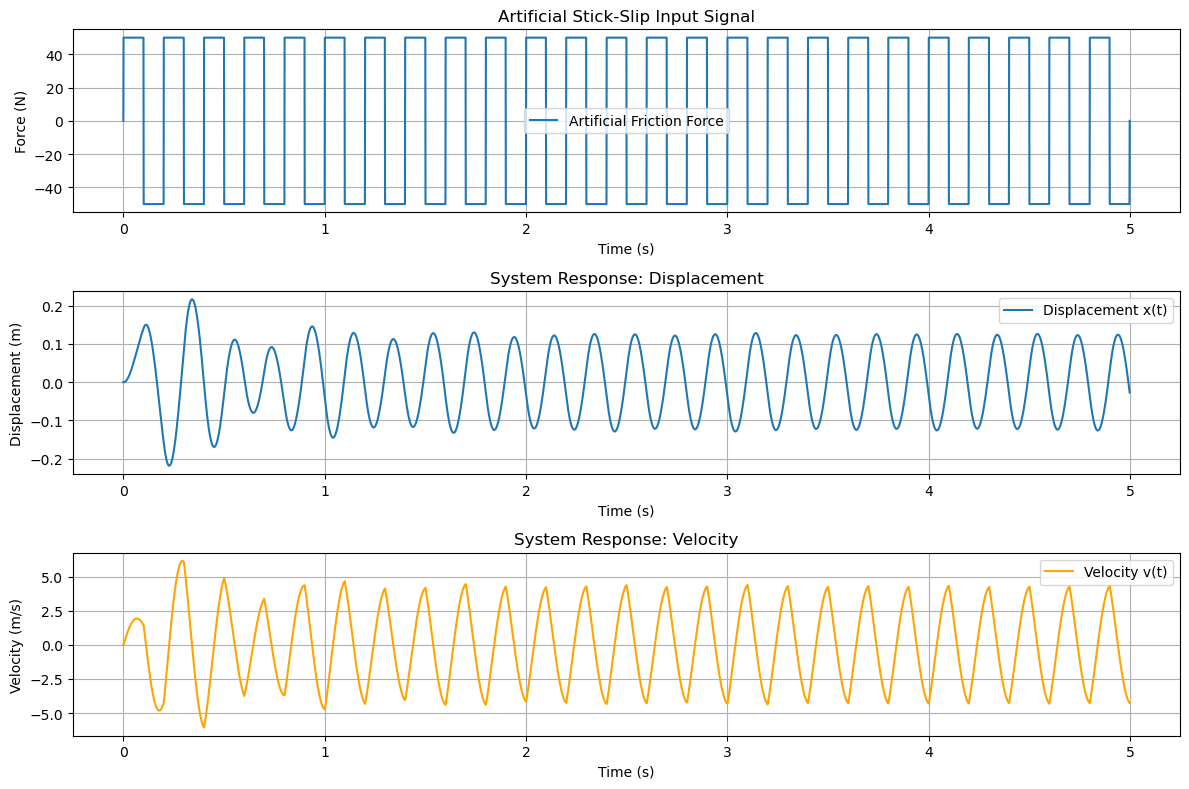

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def artificial_stribeck_input(t, freq=5.0, amplitude=50.0):
    """
    Artificial input signal mimicking a stick-slip effect.
    This function returns a square-wave like force that changes sign
    periodically at frequency 'freq'. The amplitude parameter controls 
    how much energy is injected.
    """
    return amplitude * np.sign(np.sin(2 * np.pi * freq * t))

# System parameters (single-DOF for simplicity)
m = 1.0      # mass (kg)
k = 500.0    # stiffness (N/m)
c = 5.0      # viscous damping (N·s/m)

# Time integration parameters
T_end = 5.0       # total simulation time in seconds
dt = 0.001        # time step in seconds
t_vals = np.arange(0, T_end, dt)
N = len(t_vals)

# Initialize state variables
x = np.zeros(N)   # displacement
v = np.zeros(N)   # velocity

# For illustration, we add the artificial friction force as an external force.
# This force is meant to mimic the sudden switching behavior of stick-slip friction.
F_artificial = np.zeros(N)

for i in range(N - 1):
    t = t_vals[i]
    # Compute the artificial friction (stick-slip) force input at this time
    F_artificial[i] = artificial_stribeck_input(t, freq=5.0, amplitude=50.0)
    
    # Equation of motion: m*x'' = -c*x' - k*x + F_artificial
    a = (- c * v[i] - k * x[i] + F_artificial[i]) / m
    v[i+1] = v[i] + dt * a
    x[i+1] = x[i] + dt * v[i]

# Plot the artificial input force and the system response
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t_vals, F_artificial, label='Artificial Friction Force')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Artificial Stick-Slip Input Signal')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t_vals, x, label='Displacement x(t)')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('System Response: Displacement')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t_vals, v, label='Velocity v(t)', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('System Response: Velocity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


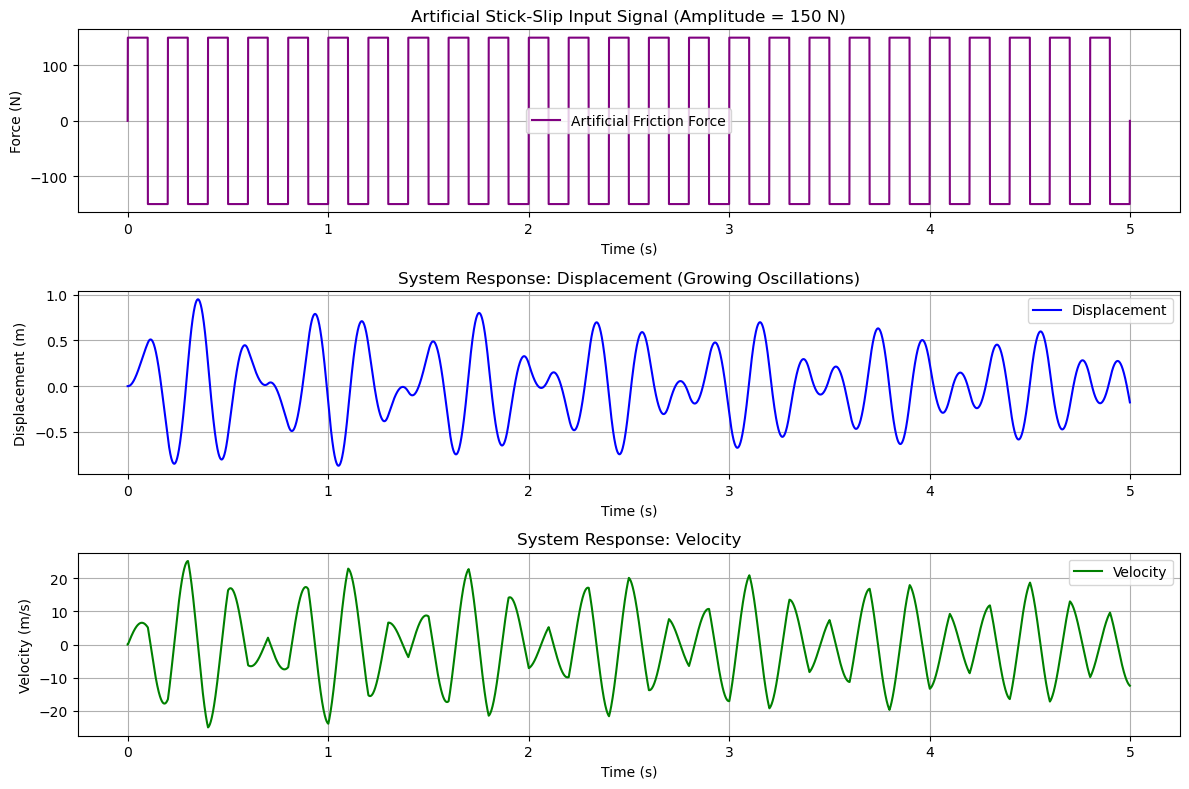

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def artificial_stribeck_input(t, freq=5.0, amplitude=150.0):
    """
    Artificial input signal mimicking a stick-slip effect.
    A square-wave force that switches sign at a given frequency.
    """
    return amplitude * np.sign(np.sin(2 * np.pi * freq * t))

# System parameters (single-DOF for simplicity)
m = 1.0      # mass (kg)
k = 500.0    # stiffness (N/m)
c = 1.0      # viscous damping (N·s/m) -- low damping to allow net energy injection

# Time integration parameters
T_end = 5.0       # total simulation time in seconds
dt = 0.001        # time step in seconds
t_vals = np.arange(0, T_end, dt)
N = len(t_vals)

# Initialize state variables
x = np.zeros(N)   # displacement
v = np.zeros(N)   # velocity
F_artificial = np.zeros(N)

# Simulation loop
for i in range(N - 1):
    t = t_vals[i]
    # Generate the artificial friction force
    F_artificial[i] = artificial_stribeck_input(t, freq=5.0, amplitude=150.0)
    
    # Equation of motion: m * x'' = - c * x' - k * x + F_artificial
    a = (- c * v[i] - k * x[i] + F_artificial[i]) / m
    v[i+1] = v[i] + dt * a
    x[i+1] = x[i] + dt * v[i]

# Plotting the artificial force and system responses
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t_vals, F_artificial, label='Artificial Friction Force', color='purple')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Artificial Stick-Slip Input Signal (Amplitude = 150 N)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t_vals, x, label='Displacement', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('System Response: Displacement (Growing Oscillations)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t_vals, v, label='Velocity', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('System Response: Velocity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Dominant frequency: 3.600 Hz (omega = 22.619 rad/s)
Phase of displacement: -0.309 rad
Desired phase for force (in-phase with velocity): 1.262 rad


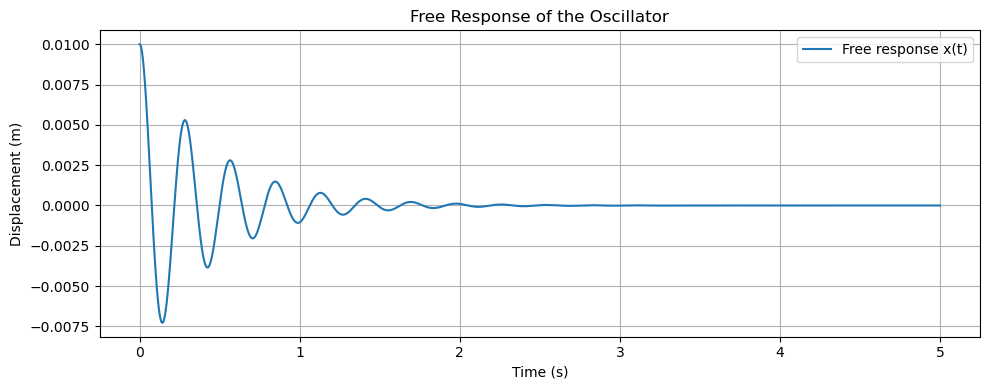

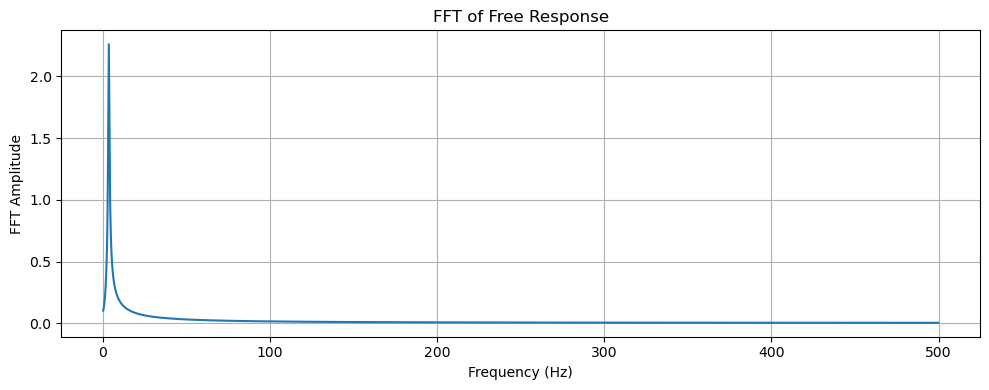

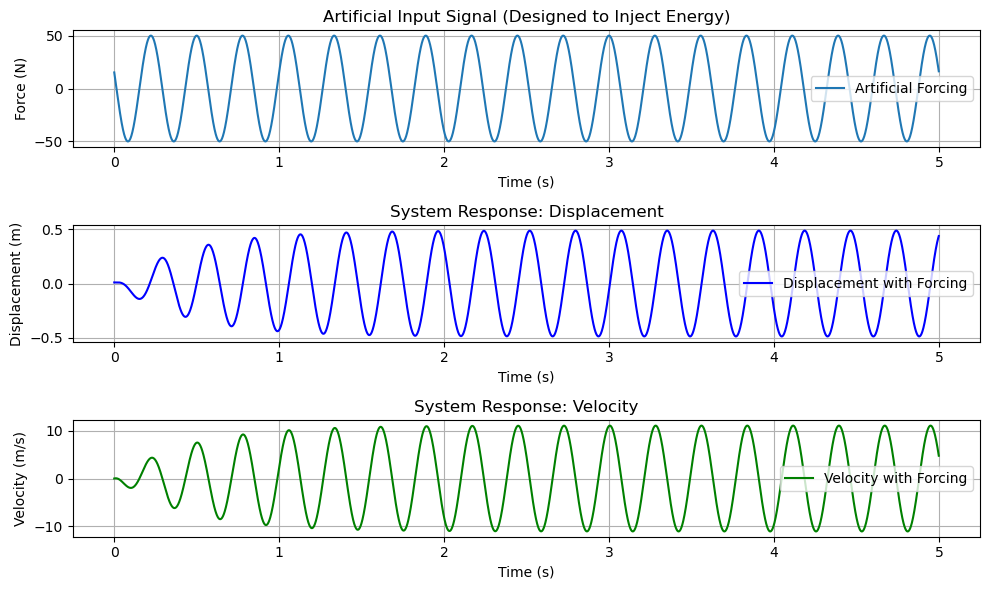

Peak displacement in early time: 4.5425e-01 m
Peak displacement in later time: 4.8868e-01 m


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# PART 1: Identify the dominant mode
# ------------------------------

# System parameters for a single-DOF oscillator
m = 1.0      # mass (kg)
k = 500.0    # stiffness (N/m)
c = 5.0      # viscous damping (N·s/m)

# Simulation parameters for free response (no forcing)
T_end = 5.0       # total simulation time (s)
dt = 0.001        # time step (s)
t_vals = np.arange(0, T_end, dt)
N = len(t_vals)

# Initialize free response arrays
x_free = np.zeros(N)
v_free = np.zeros(N)
x_free[0] = 0.01  # small initial displacement to excite the mode

# Simulate the free (undriven) oscillator
for i in range(N-1):
    a = (-c * v_free[i] - k * x_free[i]) / m
    v_free[i+1] = v_free[i] + dt * a
    x_free[i+1] = x_free[i] + dt * v_free[i]

# Compute FFT of the displacement signal to find the dominant frequency
X_fft = np.fft.fft(x_free)
freqs = np.fft.fftfreq(N, dt)

# Consider only positive frequencies
pos_inds = np.where(freqs > 0)
freqs_pos = freqs[pos_inds]
X_fft_pos = X_fft[pos_inds]

# Identify the dominant frequency (largest FFT magnitude)
index_dom = np.argmax(np.abs(X_fft_pos))
dominant_freq = freqs_pos[index_dom]      # in Hz
dominant_omega = 2 * np.pi * dominant_freq  # in rad/s

# Extract phase of the displacement at the dominant frequency
phase_x = np.angle(X_fft_pos[index_dom])
# For energy injection, we want the artificial force to be in-phase with the velocity.
# Since velocity leads displacement by 90° for a harmonic oscillator, we add pi/2.
phase_v = phase_x + np.pi/2

print("Dominant frequency: {:.3f} Hz (omega = {:.3f} rad/s)".format(dominant_freq, dominant_omega))
print("Phase of displacement: {:.3f} rad".format(phase_x))
print("Desired phase for force (in-phase with velocity): {:.3f} rad".format(phase_v))

# Plot free response and its FFT magnitude for inspection
plt.figure(figsize=(10, 4))
plt.plot(t_vals, x_free, label='Free response x(t)')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Free Response of the Oscillator')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(10, 4))
plt.plot(freqs_pos, np.abs(X_fft_pos))
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')
plt.title('FFT of Free Response')
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# PART 2: Apply artificial forcing designed to inject energy
# ------------------------------

# Choose an amplitude for the artificial forcing.
# Increase this amplitude (and/or decrease damping) until the net energy injection is positive.
F0 = 50.0  # Forcing amplitude (N)

# Create the artificial forcing signal:
# The force is set to be F(t) = F0 * cos(dominant_omega * t + phase_v)
F_art = F0 * np.cos(dominant_omega * t_vals + phase_v)

# Re-simulate the oscillator, but now include the artificial force.
x_art = np.zeros(N)
v_art = np.zeros(N)
x_art[0] = 0.01  # same initial condition
v_art[0] = 0.0

for i in range(N - 1):
    # Equation of motion: m*x'' = - c*x' - k*x + F_art(t)
    a = (-c * v_art[i] - k * x_art[i] + F_art[i]) / m
    v_art[i+1] = v_art[i] + dt * a
    x_art[i+1] = x_art[i] + dt * v_art[i]

# Plot the artificial force and the resulting response
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(t_vals, F_art, label='Artificial Forcing')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Artificial Input Signal (Designed to Inject Energy)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t_vals, x_art, label='Displacement with Forcing', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('System Response: Displacement')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t_vals, v_art, label='Velocity with Forcing', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('System Response: Velocity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Check if amplitude grows over time by comparing the peak displacement in early and later segments.
peak_early = np.max(np.abs(x_art[:N//4]))
peak_late = np.max(np.abs(x_art[3*N//4:]))
print("Peak displacement in early time: {:.4e} m".format(peak_early))
print("Peak displacement in later time: {:.4e} m".format(peak_late))


Dominant frequency: 3.600 Hz (omega = 22.619 rad/s)
Phase of displacement: -0.538 rad
Desired phase for force (in-phase with velocity): 1.032 rad


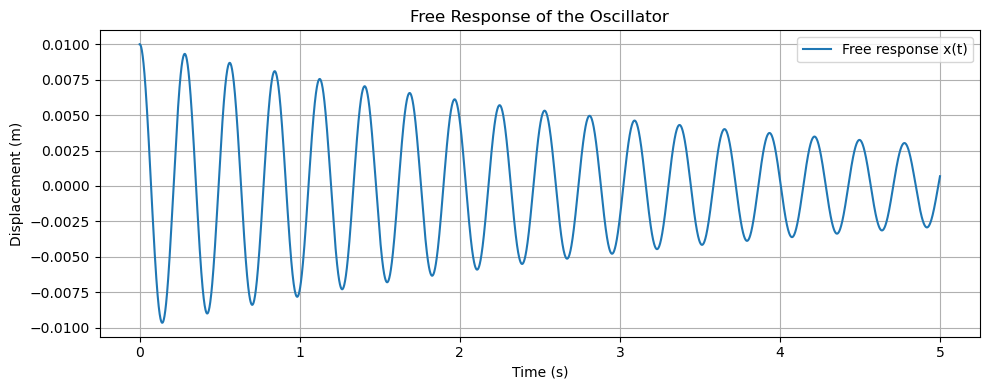

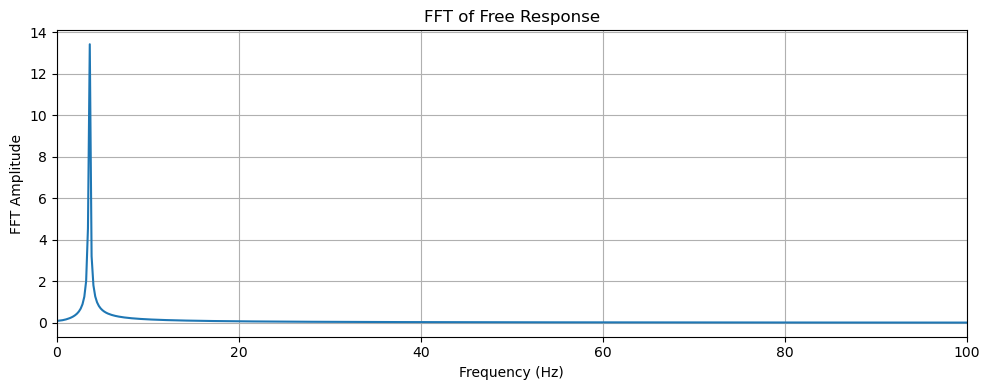

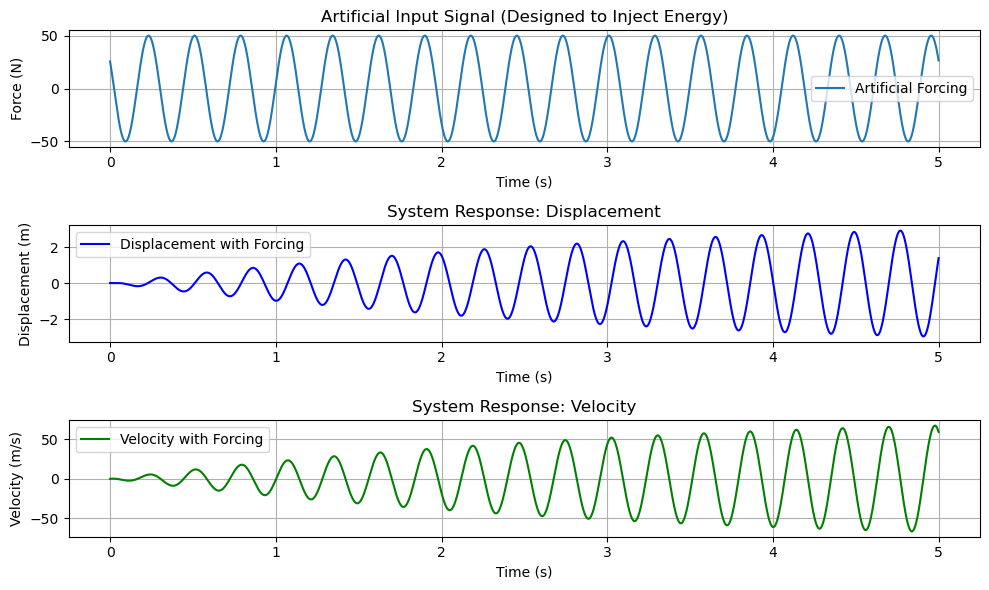

Peak displacement in early time: 1.0949e+00 m
Peak displacement in later time: 2.9592e+00 m


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# PART 1: Identify the dominant mode
# ------------------------------

# System parameters for a single-DOF oscillator
m = 1.0      # mass (kg)
k = 500.0    # stiffness (N/m)
c = 1.00      # viscous damping (N·s/m)

# Simulation parameters for free response (no forcing)
T_end = 5.0       # total simulation time (s)
dt = 0.001        # time step (s)
t_vals = np.arange(0, T_end, dt)
N = len(t_vals)

# Initialize free response arrays
x_free = np.zeros(N)
v_free = np.zeros(N)
x_free[0] = 0.01  # small initial displacement to excite the mode

# Simulate the free (undriven) oscillator
for i in range(N-1):
    a = (-c * v_free[i] - k * x_free[i]) / m
    v_free[i+1] = v_free[i] + dt * a
    x_free[i+1] = x_free[i] + dt * v_free[i]

# Compute FFT of the displacement signal to find the dominant frequency
X_fft = np.fft.fft(x_free)
freqs = np.fft.fftfreq(N, dt)

# Consider only positive frequencies
pos_inds = np.where(freqs > 0)
freqs_pos = freqs[pos_inds]
X_fft_pos = X_fft[pos_inds]

# Identify the dominant frequency (largest FFT magnitude)
index_dom = np.argmax(np.abs(X_fft_pos))
dominant_freq = freqs_pos[index_dom]      # in Hz
dominant_omega = 2 * np.pi * dominant_freq  # in rad/s

# Extract phase of the displacement at the dominant frequency
phase_x = np.angle(X_fft_pos[index_dom])
# For energy injection, we want the artificial force to be in-phase with the velocity.
# Since velocity leads displacement by 90° for a harmonic oscillator, we add pi/2.
phase_v = phase_x + np.pi/2

print("Dominant frequency: {:.3f} Hz (omega = {:.3f} rad/s)".format(dominant_freq, dominant_omega))
print("Phase of displacement: {:.3f} rad".format(phase_x))
print("Desired phase for force (in-phase with velocity): {:.3f} rad".format(phase_v))

# Plot free response and its FFT magnitude for inspection
plt.figure(figsize=(10, 4))
plt.plot(t_vals, x_free, label='Free response x(t)')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Free Response of the Oscillator')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(10, 4))
plt.plot(freqs_pos, np.abs(X_fft_pos))
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')
plt.title('FFT of Free Response')
plt.grid(True)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

# ------------------------------
# PART 2: Apply artificial forcing designed to inject energy
# ------------------------------

# Choose an amplitude for the artificial forcing.
# Increase this amplitude (and/or decrease damping) until the net energy injection is positive.
F0 = 50.0  # Forcing amplitude (N)

# Create the artificial forcing signal:
# The force is set to be F(t) = F0 * cos(dominant_omega * t + phase_v)
F_art = F0 * np.cos(dominant_omega * t_vals + phase_v)

# Re-simulate the oscillator, but now include the artificial force.
x_art = np.zeros(N)
v_art = np.zeros(N)
x_art[0] = 0.01  # same initial condition
v_art[0] = 0.0

for i in range(N - 1):
    # Equation of motion: m*x'' = - c*x' - k*x + F_art(t)
    a = (-c * v_art[i] - k * x_art[i] + F_art[i]) / m
    v_art[i+1] = v_art[i] + dt * a
    x_art[i+1] = x_art[i] + dt * v_art[i]

# Plot the artificial force and the resulting response
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(t_vals, F_art, label='Artificial Forcing')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Artificial Input Signal (Designed to Inject Energy)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t_vals, x_art, label='Displacement with Forcing', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('System Response: Displacement')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t_vals, v_art, label='Velocity with Forcing', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('System Response: Velocity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Check if amplitude grows over time by comparing the peak displacement in early and later segments.
peak_early = np.max(np.abs(x_art[:N//4]))
peak_late = np.max(np.abs(x_art[3*N//4:]))
print("Peak displacement in early time: {:.4e} m".format(peak_early))
print("Peak displacement in later time: {:.4e} m".format(peak_late))


Component at omega = 20.0 rad/s:
   Main mass (X1) = 2.3326e-02 m, phase = -0.176 rad
   TMD      (X2) = 1.0863e-01 m, phase = -0.477 rad

Component at omega = 40.0 rad/s:
   Main mass (X1) = 9.4065e-03 m, phase = -3.034 rad
   TMD      (X2) = 4.3187e-03 m, phase = 0.338 rad



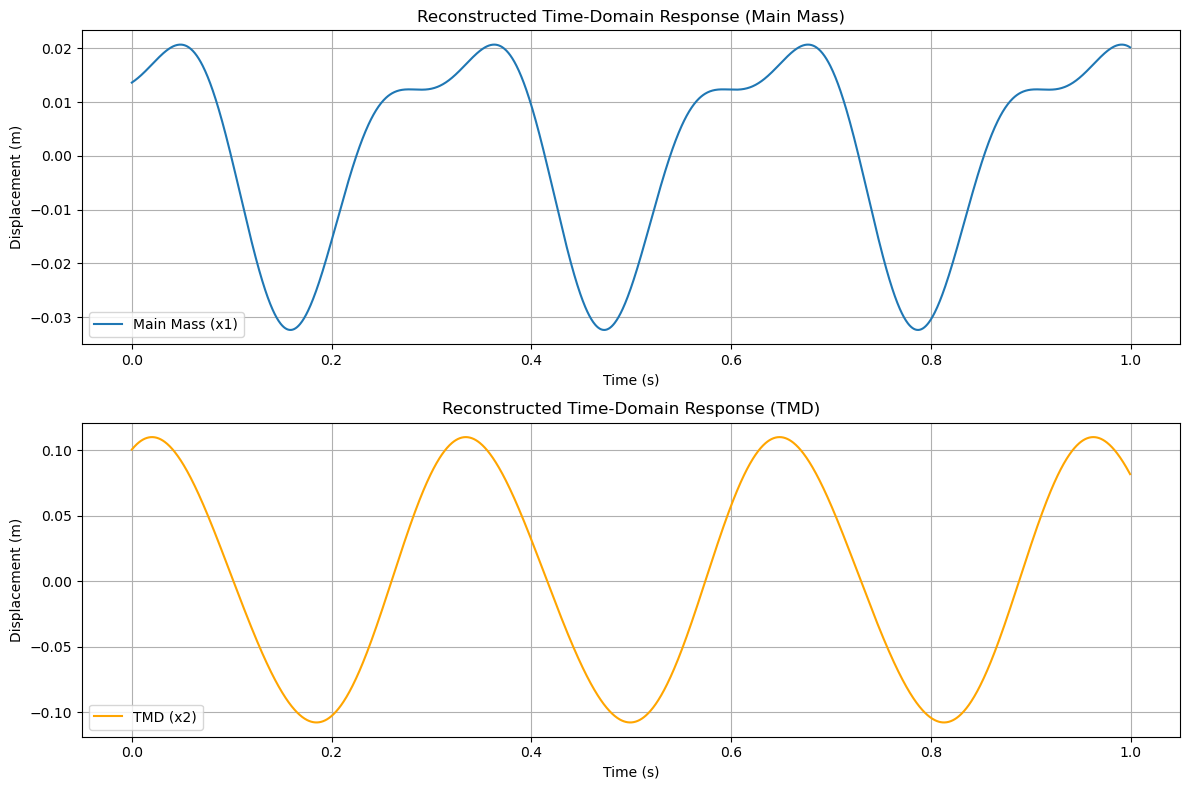

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# System parameters for the TMD model
# -------------------------------
m1 = 10.0      # Main mass (kg)
m2 = 1.0       # TMD mass (kg)

# Stiffness parameters
k1 = 1e4       # Stiffness between main mass and ground (N/m)
k2 = 500.0     # Stiffness of TMD connection (N/m)

# Damping parameters
c1 = 10.0      # Damping between main mass and ground (N·s/m)
c2 = 2.0       # Damping of TMD connection (N·s/m)

# Assemble mass, damping, and stiffness matrices (2x2)
M = np.diag([m1, m2])
# For this example the stiffness matrix reflects that the main mass is connected to ground via k1, and
# the TMD is connected to the main mass via k2. (A simplified connectivity.)
K = np.array([[k1+k2,    -k2],
              [-k2,       k2]])
C = np.array([[c1+c2,    -c2],
              [-c2,       c2]])

# -------------------------------
# Forcing function composed of multiple harmonics
# -------------------------------
# Define two forcing components:
# We assume the forcing is applied to the main mass only (first DOF) as:
# F(omega) = [F_amp; 0]
# with different frequencies.
forcing_components = [
    {'omega': 20.0, 'F_amp': 100.0},  # first component: 20 rad/s, amplitude 100 N
    {'omega': 40.0, 'F_amp': 50.0}     # second component: 40 rad/s, amplitude 50 N
]

# For each component, the forcing vector is:
# F = [ (j*omega*c1 + k1)*Y0 ] for a base excitation formulation,
# but here we simply use a direct force amplitude (applied on mass 1) for illustration.
# We'll define F_vec = [F_amp, 0] (complex valued) for each harmonic.

# -------------------------------
# Frequency-domain solution for each component
# -------------------------------
responses = []  # to store computed responses for each component
for comp in forcing_components:
    omega = comp['omega']
    F_amp = comp['F_amp']
    # Forcing vector: applied to DOF 1 only.
    F_vec = np.array([F_amp, 0], dtype=complex)
    # Construct the dynamic matrix A(omega) = -omega^2*M + j*omega*C + K
    A = -omega**2 * M + 1j*omega * C + K
    # Solve A * X = F_vec
    X = np.linalg.solve(A, F_vec)
    responses.append({'omega': omega, 'X': X})

    print(f"Component at omega = {omega:.1f} rad/s:")
    print(f"   Main mass (X1) = {np.abs(X[0]):.4e} m, phase = {np.angle(X[0]):.3f} rad")
    print(f"   TMD      (X2) = {np.abs(X[1]):.4e} m, phase = {np.angle(X[1]):.3f} rad")
    print("")

# -------------------------------
# Time-domain reconstruction via superposition
# -------------------------------
T_end = 1.0      # total time for reconstruction (s)
dt = 0.0005
t_vals = np.arange(0, T_end, dt)
x1_total = np.zeros_like(t_vals)  # response of main mass
x2_total = np.zeros_like(t_vals)  # response of TMD

# For each forcing component, add its contribution:
for comp in responses:
    omega = comp['omega']
    X = comp['X']  # X[0] for main mass, X[1] for TMD
    # The time-domain contribution from this frequency is the real part of X * exp(j omega t)
    x1_total += np.real( X[0] * np.exp(1j * omega * t_vals) )
    x2_total += np.real( X[1] * np.exp(1j * omega * t_vals) )

# -------------------------------
# Plot the reconstructed time-domain responses
# -------------------------------
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t_vals, x1_total, label="Main Mass (x1)")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.title("Reconstructed Time-Domain Response (Main Mass)")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_vals, x2_total, label="TMD (x2)", color='orange')
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.title("Reconstructed Time-Domain Response (TMD)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Component at omega = 20.0 rad/s:
   Main mass (X1) = 2.3326e-02 m, phase = -0.176 rad
   TMD      (X2) = 1.0863e-01 m, phase = -0.477 rad

Component at omega = 40.0 rad/s:
   Main mass (X1) = 9.4065e-03 m, phase = -3.034 rad
   TMD      (X2) = 4.3187e-03 m, phase = 0.338 rad



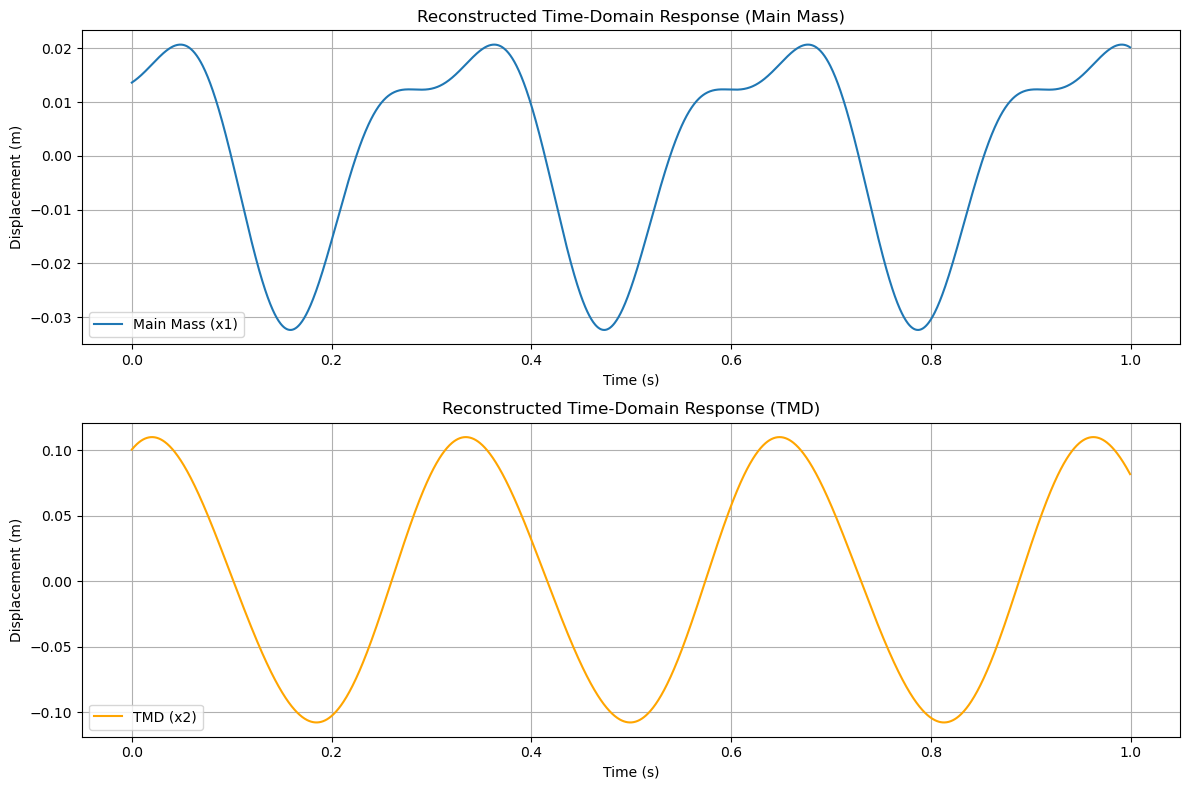

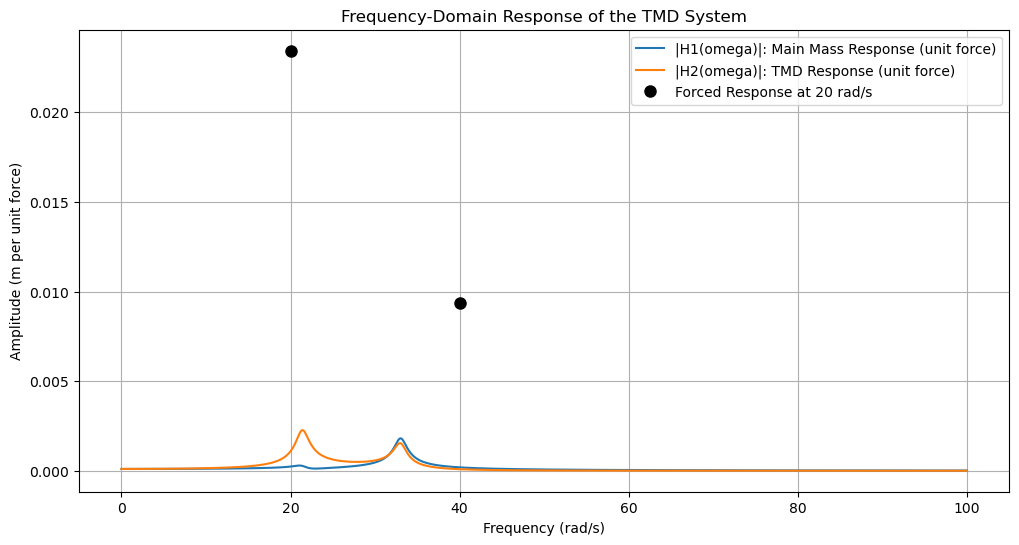

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# TMD System Parameters (Two-mass model)
# -------------------------------
m1 = 10.0      # Main mass (kg)
m2 = 1.0       # TMD mass (kg)

# Stiffness parameters
k1 = 1e4       # Stiffness between main mass and ground (N/m)
k2 = 500.0     # Stiffness of TMD connection (N/m)

# Damping parameters
c1 = 10.0      # Damping between main mass and ground (N·s/m)
c2 = 2.0       # Damping of TMD connection (N·s/m)

# Assemble matrices for the two-DOF system:
M = np.diag([m1, m2])
K = np.array([[k1+k2,    -k2],
              [-k2,       k2]])
C = np.array([[c1+c2,    -c2],
              [-c2,       c2]])

# -------------------------------
# Forcing Function Composed of Multiple Harmonics
# -------------------------------
# We define two forcing components applied to the main mass only:
forcing_components = [
    {'omega': 20.0, 'F_amp': 100.0},  # Component 1: 20 rad/s, amplitude 100 N
    {'omega': 40.0, 'F_amp': 50.0}      # Component 2: 40 rad/s, amplitude 50 N
]

# Frequency-domain analysis for each component:
responses = []  # List to store computed responses for each component
for comp in forcing_components:
    omega = comp['omega']
    F_amp = comp['F_amp']
    # Forcing vector: applied only to DOF 1.
    F_vec = np.array([F_amp, 0], dtype=complex)
    # Dynamic matrix: A(omega) = -omega^2*M + j*omega*C + K
    A = -omega**2 * M + 1j*omega * C + K
    X = np.linalg.solve(A, F_vec)
    responses.append({'omega': omega, 'F_amp': F_amp, 'X': X})
    print(f"Component at omega = {omega:.1f} rad/s:")
    print(f"   Main mass (X1) = {np.abs(X[0]):.4e} m, phase = {np.angle(X[0]):.3f} rad")
    print(f"   TMD      (X2) = {np.abs(X[1]):.4e} m, phase = {np.angle(X[1]):.3f} rad")
    print("")

# -------------------------------
# Time-domain Reconstruction via Superposition
# -------------------------------
T_end = 1.0      # total time for reconstruction (s)
dt = 0.0005
t_vals = np.arange(0, T_end, dt)
x1_total = np.zeros_like(t_vals)  # main mass displacement
x2_total = np.zeros_like(t_vals)  # TMD displacement

for comp in responses:
    omega = comp['omega']
    X = comp['X']  # X[0] for main mass, X[1] for TMD
    # Time-domain contribution: Real{ X * exp(j*omega*t) }
    x1_total += np.real( X[0] * np.exp(1j * omega * t_vals) )
    x2_total += np.real( X[1] * np.exp(1j * omega * t_vals) )

# -------------------------------
# Frequency Response: Sweep over a range and compute unit response
# -------------------------------
omega_range = np.linspace(0, 100, 1000)
H1 = np.zeros_like(omega_range, dtype=complex)  # main mass transfer function (unit forcing)
H2 = np.zeros_like(omega_range, dtype=complex)  # TMD transfer function

for i, omega in enumerate(omega_range):
    A = -omega**2 * M + 1j*omega * C + K
    # Unit forcing: [1; 0]
    F_unit = np.array([1, 0], dtype=complex)
    X = np.linalg.solve(A, F_unit)
    H1[i] = X[0]
    H2[i] = X[1]

# -------------------------------
# Plotting Results
# -------------------------------

# (A) Time-domain Reconstruction
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.plot(t_vals, x1_total, label="Main Mass (x1)")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.title("Reconstructed Time-Domain Response (Main Mass)")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(t_vals, x2_total, label="TMD (x2)", color='orange')
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.title("Reconstructed Time-Domain Response (TMD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# (B) Frequency-Domain Response
plt.figure(figsize=(12, 6))
plt.plot(omega_range, np.abs(H1), label="|H1(omega)|: Main Mass Response (unit force)")
plt.plot(omega_range, np.abs(H2), label="|H2(omega)|: TMD Response (unit force)")
# Mark the forcing frequencies (scaled by their amplitudes)
for comp in responses:
    omega = comp['omega']
    F_amp = comp['F_amp']
    # For a unit response, the forced response amplitude is F_amp * |H|
    # Find the index corresponding to this omega
    idx = np.argmin(np.abs(omega_range - omega))
    plt.plot(omega, F_amp * np.abs(H1[idx]), 'ko', markersize=8,
             label=f"Forced Response at {omega:.0f} rad/s" if omega==forcing_components[0]['omega'] else None)

plt.xlabel("Frequency (rad/s)")
plt.ylabel("Amplitude (m per unit force)")
plt.title("Frequency-Domain Response of the TMD System")
plt.legend()
plt.grid(True)
plt.show()
